---
title: "CAVE Query: Synaptic Connectivity"
aliases:
    - em_py_03_download_cell_connectivity.html
    - ../programmatic_access/em_py_03_download_cell_connectivity.html
format: 
    html:
        toc: true 
        code-fold: false
        code-links:
          - text: Download Quickstart Notebooks
            icon: file-code
            href: https://github.com/AllenInstitute/microns_tutorial/tree/main/tutorial_book/quickstart_notebooks
execute:
    eval: False
    warning: False
jupyter: python3
---

{{< include ../_annotation_tables/_version_warning.qmd >}}

The **Connectome Annotation Versioning Engine (CAVE)** is a suite of tools developed at the Allen Institute and Seung Lab to manage large connectomics data.  

::: {.callout-important}
## Initial Setup
Before using any programmatic access to the data, [you first need to set up your CAVEclient token](em_py_01_caveclient_setup.html).
:::

The connectome data (synapses, cell types, etc.) can be accessed from the cloud via CAVE. However, because of the size of the connectivity tables, it is often preferable to download and compile the features of interest (in this case synapses) to work with offline. This notebook steps through downloading the synapses of the proofread neurons, as of materialization version 1300.  

::: {.callout-tip}
## Quickstart
It is recommended you have worked through the [CAVE Quickstart](em_py_02_cave_quickstart.html) notebook, as this tutorial builds on knowledge in the previous notebook.
:::

## Initialize CAVEclient with a datastack
    
Datasets in CAVE are organized as datastacks. These are a combination of an EM dataset, a segmentation and a set of annotations. The datastack for MICrONS public release is `minnie65_public`. When you instantiate your client with this datastack, it loads all relevant information to access it.   
    

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from caveclient import CAVEclient
client = CAVEclient("minnie65_public")

### Materialization versions

Data in CAVE is timestamped and periodically versioned - each (materialization) version corresponds to a specific timestamp. Individual versions are made publicly available. The Materialization client allows one to interact with the materialized annotation tables that were posted to the annotation service. These are called **queries** to the dataset, and available from `client.materialize`. For more, see the [CAVEclient Documentation](https://caveconnectome.github.io/CAVEclient/tutorials/materialization/).

Periodic updates are made to the public datastack, which will include updates to the available tables. Some cells will have different `pt_root_id` because they have undergone [proofreading](../proofreading.html). 

::: {.callout-tip}
For analysis consistency, is worth checking the version of the data you are using, and consider specifying the version with `client.version = your_version`

Read more about [setting the version of your analysis](/materialization-version.html#how-to-set-the-version-of-your-analysis)
:::

In [2]:
client.materialize.get_versions()

[1300, 1078, 117, 661, 343, 1181, 795, 943, 1412]

And these are their associated timestamps (all timestamps are in UTC):



In [3]:
for version in client.materialize.get_versions():
    print(f"Version {version}: {client.materialize.get_timestamp(version)}")

Version 1300: 2025-01-13 10:10:01.286229+00:00
Version 1078: 2024-06-05 10:10:01.203215+00:00
Version 117: 2021-06-11 08:10:00.215114+00:00
Version 661: 2023-04-06 20:17:09.199182+00:00
Version 343: 2022-02-24 08:10:00.184668+00:00
Version 1181: 2024-09-16 10:10:01.121167+00:00
Version 795: 2023-08-23 08:10:01.404268+00:00
Version 943: 2024-01-22 08:10:01.497934+00:00
Version 1412: 2025-04-29 10:10:01.200893+00:00


The client will automatically query the latest materialization version. You can specify a `materialization_version` for every query if you want to access a specific version.


In [4]:
# set materialization version, for consistency
client.version = 1412 # current public as of 4/29/2025

## Querying Synapses

While synapses are stored as any other table in the database, in this case `synapses_pni_2`, this table is much larger than any other table at more than 337 million rows:

In [5]:
client.materialize.get_annotation_count('synapses_pni_2')

337312429

While we can query the synapse table directly, this is generally not recommended. It is too large to query all at once. CAVE limits to queries to 500,000 rows at once and will display a warning when that happens. Here, we demonstrate this with the limit set to 10:

In [6]:
synapse_table_name = client.info.get_datastack_info()["synapse_table"]
syn_df = client.materialize.query_table(synapse_table_name, limit=10, desired_resolution=[1, 1, 1], split_positions=True)
syn_df

201 - "Limited query to 10 rows


,id,created,superceded_id,valid,pre_pt_position_x,pre_pt_position_y,pre_pt_position_z,post_pt_position_x,post_pt_position_y,post_pt_position_z,ctr_pt_position_x,ctr_pt_position_y,ctr_pt_position_z,size,pre_pt_supervoxel_id,pre_pt_root_id,post_pt_supervoxel_id,post_pt_root_id
0,4456,2020-11-04 13:02:08.388988+00:00,NaN,t,211448.0,409744.0,801440.0,211448.0,409744.0,801440.0,211612.0,410172.0,801400.0,2956,72063160986635724,864691135533713769,72063160986635724,864691135533713769
1,4503,2020-11-04 12:09:33.286834+00:00,NaN,t,212456.0,408032.0,800360.0,212456.0,408032.0,800360.0,212168.0,408088.0,800400.0,344,72063092267156962,864691135087527094,72063092267156962,864691135087527094
2,4508,2020-11-04 13:02:13.024144+00:00,NaN,t,212448.0,411696.0,801440.0,212448.0,411696.0,801440.0,212224.0,411800.0,801560.0,344,72063229706111827,864691135533713769,72063229706111827,864691135533713769
3,4568,2020-11-04 13:44:08.085705+00:00,NaN,t,213392.0,415448.0,802920.0,213392.0,415448.0,802920.0,213096.0,415176.0,802880.0,13816,72133735889250131,864691134530418554,72133735889250131,864691134530418554
4,4581,2020-11-04 07:29:12.917622+00:00,NaN,t,213552.0,417184.0,800800.0,213552.0,417184.0,800800.0,213240.0,417080.0,801080.0,10436,72133804608718799,864691134745062676,72133804608718799,864691134745062676
5,4582,2020-11-04 13:02:17.694701+00:00,NaN,t,212880.0,409120.0,801440.0,212880.0,409120.0,801440.0,213016.0,408832.0,801520.0,1344,72063160986636743,864691135533713769,72063160986636743,864691135533713769
6,4588,2020-11-04 12:20:12.290593+00:00,NaN,t,213200.0,421120.0,805520.0,213200.0,421120.0,805520.0,213064.0,421000.0,805600.0,7128,72133942047682150,864691134609767690,72133942047682150,864691134609767690
7,4590,2020-11-04 13:20:01.875310+00:00,NaN,t,213504.0,406440.0,805160.0,213504.0,406440.0,805160.0,213336.0,406596.0,805200.0,6572,72133461011344162,864691135091400630,72133461011344162,864691135091400630
8,4606,2020-11-04 07:24:39.038223+00:00,NaN,t,213384.0,413792.0,800800.0,213384.0,413792.0,800800.0,213256.0,413976.0,801040.0,2100,72133667169766499,864691134609872906,72133667169766499,864691134609872906
9,4611,2020-11-04 07:24:37.800341+00:00,NaN,t,213336.0,415304.0,800960.0,213336.0,415304.0,800960.0,213192.0,415604.0,800960.0,492,72133735889243887,864691134609872906,72133735889243887,864691134609872906


Instead, you have several options for querying cells of interest:

* Specifying the `pre_ids`
* Specifying the `post_ids`
* Searching within a `bounding_box`
* Using a combination of the above to iterate through large numbers of neurons


### Query synapses given `pt_root_id` of interest

The `synapse_query` function allows you to query the synapse table in a more convenient way than most other tables.
In particular, the `pre_ids` and `post_ids` let you specify which root id (or collection of root ids) you want to query, with pre_ids indicating the collection of **presynaptic neurons** and post_ids the collection of **postsynaptic neurons**.

Using both `pre_ids` and `post_ids` in one call is effectively a logical AND, returning only those synapses from neurons in the list of `pre_ids` that target neurons in the list of `post_ids`.

Let's look at one particular example.

In [9]:
# Pick example cell
example_root_id = 864691136968109774

# Query synapse table with synapse_query()
input_syn_df = client.materialize.synapse_query(post_ids=example_root_id)

print(f"Total number of input synapses for {example_root_id}: {len(input_syn_df)}")
input_syn_df.head()

Total number of input synapses for 864691136968109774: 4628


,id,created,superceded_id,valid,size,pre_pt_supervoxel_id,pre_pt_root_id,post_pt_supervoxel_id,post_pt_root_id,pre_pt_position,post_pt_position,ctr_pt_position
0,165943687,2020-11-04 06:48:59.403833+00:00,NaN,t,6068,89667372671545980,864691135522708676,89667372671554898,864691136968109774,"[181250, 191912, 18361]","[181278, 191844, 18364]","[181276, 191873, 18366]"
1,155169887,2020-11-04 06:49:11.336675+00:00,NaN,t,964,88540717118418517,864691135412525042,88540717051854108,864691136968109774,"[172816, 186434, 19971]","[172892, 186468, 19969]","[172821, 186483, 19965]"
2,175655972,2020-11-04 06:48:59.403833+00:00,NaN,t,260,90230391344454185,864691136711146862,90160022600247406,864691136968109774,"[184962, 192380, 18359]","[184836, 192448, 18366]","[184916, 192396, 18359]"
3,169597812,2020-11-04 06:49:11.962249+00:00,NaN,t,7164,89598584945119102,864691135459877874,89598584945109756,864691136968109774,"[180636, 203654, 21957]","[180706, 203762, 21963]","[180680, 203716, 21959]"
4,159676064,2020-11-04 06:48:59.876707+00:00,NaN,t,14460,89385691939052008,864691135773033723,89385691939060896,864691136968109774,"[178870, 190176, 21429]","[178870, 190204, 21437]","[178878, 190132, 21434]"


In [10]:
# Query synapse table with synapse_query()
output_syn_df = client.materialize.synapse_query(pre_ids=example_root_id)

print(f"Total number of output synapses for {example_root_id}: {len(output_syn_df)}")
output_syn_df.head()

Total number of output synapses for 864691136968109774: 1499


,id,created,superceded_id,valid,size,pre_pt_supervoxel_id,pre_pt_root_id,post_pt_supervoxel_id,post_pt_root_id,pre_pt_position,post_pt_position,ctr_pt_position
0,158405512,2020-11-04 06:48:59.403833+00:00,NaN,t,420,89385416926790697,864691136968109774,89385416926797494,864691135546540484,"[179076, 188248, 20233]","[179156, 188220, 20239]","[179140, 188230, 20239]"
1,185549462,2020-11-04 06:49:10.903020+00:00,NaN,t,4832,91356016507479890,864691136968109774,91356016507470163,864691135884799088,"[193168, 190452, 19262]","[193142, 190404, 19257]","[193180, 190432, 19254]"
2,138110803,2020-11-04 06:49:46.758528+00:00,NaN,t,3176,87263084540201919,864691136968109774,87263084540199587,864691135060075931,"[163440, 104292, 19808]","[163498, 104348, 19806]","[163460, 104356, 19804]"
3,157378264,2020-11-04 07:38:27.332669+00:00,NaN,t,412,89374490395905686,864691136968109774,89374490395921430,864691135446953106,"[179218, 107132, 19372]","[179204, 107010, 19383]","[179196, 107072, 19380]"
4,148262628,2020-11-04 06:53:27.294021+00:00,NaN,t,3536,88189766885093187,864691136968109774,88189835604584343,864691135250533976,"[170154, 193170, 21123]","[170046, 193240, 21123]","[170118, 193220, 21128]"


Note that synapse queries always return the list of every synapse between the neurons in the query, even if there are multiple synapses between the same pair of neurons.

A common pattern to generate a list of connections between unique pairs of neurons is to group by the root ids of the presynaptic and postsynaptic neurons and then count the number of synapses between them.
For example, use `pandas.groupby()` to get the number of synapses from this neuron onto every other neuron:

In [11]:
# get count of synapses between presynaptic and postsynaptic partners
output_syn_df.groupby(
  ['pre_pt_root_id', 'post_pt_root_id']
).count()[['id']].rename(
  columns={'id': 'syn_count'}
).sort_values(
  by='syn_count',
  ascending=False,
)
# Note that the 'id' part here is just a way to quickly extract one column. This could be any of the remaining column names, 
# but `id` is often convenient because it is common to all tables.

syn_count
pre_pt_root_id     post_pt_root_id              
864691136968109774 864691135280056225         20
                   864691135456207722         16
                   864691134949547516         15
                   864691135784316467         13
                   864691136275521549         11
...                                          ...
                   864691136911628017          1
                   864691135234846808          1
                   864691135236362017          1
                   864691136913679601          1
                   864691136965772238          1

[1035 rows x 1 columns]

### Query synapses given `bounding_box` of interest

The `synapse_query()` can find all synapses in an arbitrary space of the volume. This is useful if, for example, you want to find all synapses in a radius around one synapse of interest, such as for building a null-model of connectivity based on proximity.

```python
bounding_box = [[min_x, min_y, min_z], [max_x, max_y, max_z]]
df=client.materialize.query_table(post_ids = example_root_id,
                                  bounding_box=bounding_box)

```

For more details, see the [CAVEclient documentation](https://caveconnectome.github.io/CAVEclient/tutorials/materialization/#synapse-query). Also compare to bounding box downloads through cloud-volume in the [next quickstart notebooks](05-cloudvolume-download.html).

## Query proofread cells and connectivity

### Proofread neurons

The table `proofreading_status_and_strategy` contains proofreading information about ~2000 neurons. For more on interpretting and using the proofreading table, see [the previous quickstart notebook](03-cave-query-proofread-cells.html).

Here we query all neurons in the dataset that have proofread axons

In [12]:
proof_df = client.materialize.tables.proofreading_status_and_strategy(status_axon='t').query(desired_resolution=[1, 1, 1], split_positions=True)
proof_df["strategy_axon"].value_counts()

strategy_axon
axon_partially_extended    1702
axon_fully_extended         156
axon_interareal             124
Name: count, dtype: int64

### Query synapses between proofread neurons

We can query the graph spanned by the neurons with proofread axons using synapse query.

::: {.callout-tip}
Here we specify both the `pre_ids` and `post_ids`, meaning we will only be interpretting the connectivity between cells that **both have proofread axons**. This makes plotting the square connectivity matrix easier.

However, connectivity between two cells is generally interpretable even if only the **presynaptic cell has axon proofreading**. Meaning, you can remove the `post_ids` argument in the section below, and still have interpretable data. 

:::

In [13]:
%%time
# This takes 4-6 minutes to complete
syn_proof_only_df = client.materialize.synapse_query(pre_ids=proof_df.pt_root_id,
                                                  post_ids=proof_df.pt_root_id,
                                                  remove_autapses=True,
                                                 )

print(len(syn_proof_only_df))

183905
CPU times: total: 1.17 s
Wall time: 6min 14s


### Plot connectivity as binarized heatmap
Now lets plot the connectivity between every proofread cell and every other cell. This uses the `pandas.pivot_table()` to turn the long-form synapse table into a connectivity matrix. 

In [14]:
%%time
# This takes 2 minutes to complete
syn_mat = syn_proof_only_df.pivot_table(index="pre_pt_root_id", 
                                        columns="post_pt_root_id", 
                                        values="size", 
                                        aggfunc=lambda x: float(np.sum(x) > 0)
                                       ).fillna(0)
syn_mat = syn_mat.reindex(columns=np.array(syn_mat.index))

CPU times: total: 1min 49s
Wall time: 2min 37s


Plot the binarized connectivity with Seaborn `heatmap()`:

Text(0.5, 1.0, 'Connectivity between proofread cells')

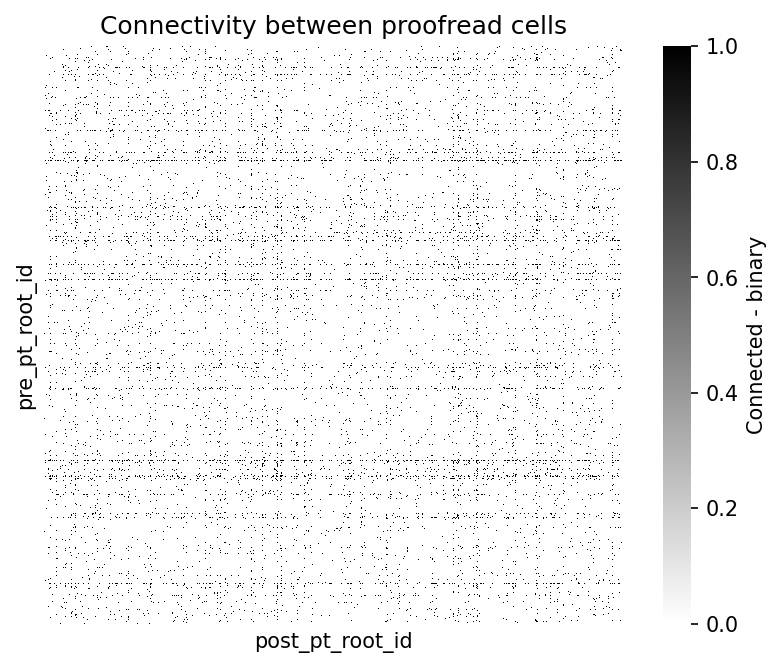

In [15]:
fig, ax = plt.subplots(figsize=(7, 5), dpi=150)
sns.heatmap(syn_mat, cmap="gray_r", xticklabels=[], yticklabels=[], 
            ax=ax, square=True,
            cbar_kws={"label": "Connected - binary"})

ax.set_title('Connectivity between proofread cells')

There is some structure of highly interconnected cells. By adding information about the type of cells, we might infer more about the connectivity patterns

## Add cell type information to connectivity

### Querying cell type information 

There are two distinct ways cell types were classified in the MICrONS dataset: manual and automated. Manual annotations are available for ~1,000 neurons (`allen_v1_column_types_slanted_ref`), automated classifications are available for all cell bodies based on these manual annotations (`aibs_metamodel_celltypes_v661`). For more about querying cell types tables, see the [previous quickstart notebook](02-cave-query-cell-types.html).

::: {.callout-tip}
For more on cell types and how to interpret them, see the [Annotation Tables](/annotation-tables.html#cell-type-tables) page.

:::

In [16]:
ct_manual_df = client.materialize.tables.allen_v1_column_types_slanted_ref().query()

# rename the reference column for clarity
ct_manual_df.rename(columns={'target_id': 'nucleus_id'}, inplace=True)

# remove segments with multiple cell bodies
ct_manual_df.drop_duplicates("pt_root_id", keep=False, inplace=True)
ct_manual_df.head(5)

The `client.materialize.tables` interface is experimental and might experience breaking changes before the feature is stabilized.


,id,created,valid,volume,pt_supervoxel_id,pt_root_id,id_ref,created_ref,valid_ref,nucleus_id,classification_system,cell_type,pt_position,bb_start_position,bb_end_position
0,258319,2020-09-28 22:40:42.476911+00:00,t,261.806162,89309001002848425,864691136021936376,50,2023-03-18 14:13:21.613360+00:00,t,258319,aibs_coarse_excitatory,23P,"[178400, 143248, 21238]","[nan, nan, nan]","[nan, nan, nan]"
1,276438,2020-09-28 22:40:42.700226+00:00,t,277.317714,89465269428261699,864691135164434989,1119,2023-03-18 14:13:22.506660+00:00,t,276438,aibs_coarse_excitatory,6P-CT,"[179648, 258768, 23597]","[nan, nan, nan]","[nan, nan, nan]"
2,260552,2020-09-28 22:40:42.745779+00:00,t,230.111805,89170256379033022,864691135784109363,35,2023-03-18 14:13:21.602813+00:00,t,260552,aibs_coarse_excitatory,23P,"[177408, 157968, 21002]","[nan, nan, nan]","[nan, nan, nan]"
3,260263,2020-09-28 22:40:42.746658+00:00,t,274.324193,88044356338331571,864691135694415551,95,2023-03-18 14:13:21.644304+00:00,t,260263,aibs_coarse_excitatory,23P,"[169440, 158128, 20266]","[nan, nan, nan]","[nan, nan, nan]"
4,262898,2020-09-28 22:40:42.749245+00:00,t,230.092308,88468836747612860,864691135778773856,81,2023-03-18 14:13:21.634505+00:00,t,262898,aibs_coarse_inhibitory,BPC,"[172512, 175280, 21964]","[nan, nan, nan]","[nan, nan, nan]"


This table is a reference on the `nucleus_detection_v0` table, and adds two additional data columns: `classification_system` and `cell_type`. The `classification_system` divides the cells into excitatitory and inhibitory neurons as well as non-neuronal cells. `cell_type` provides lower level cell annotations. 

Next, we query the automatically classified cell type information. The query works the same way:

In [17]:
ct_auto_df = client.materialize.tables.aibs_metamodel_celltypes_v661().query()

# rename the reference column for clarity
ct_auto_df.rename(columns={'target_id': 'nucleus_id'}, inplace=True)

# remove segments with multiple cell bodies
ct_auto_df.drop_duplicates("pt_root_id", keep=False, inplace=True)
ct_auto_df.head(5)

The `client.materialize.tables` interface is experimental and might experience breaking changes before the feature is stabilized.


,id,created,valid,volume,pt_supervoxel_id,pt_root_id,id_ref,created_ref,valid_ref,nucleus_id,classification_system,cell_type,pt_position,bb_start_position,bb_end_position
0,336365,2020-09-28 22:42:48.966292+00:00,t,272.488202,93606511657924288,864691136274724621,36916,2023-12-19 22:47:18.659864+00:00,t,336365,excitatory_neuron,5P-IT,"[209760, 180832, 27076]","[nan, nan, nan]","[nan, nan, nan]"
1,110648,2020-09-28 22:45:09.650639+00:00,t,328.533443,79385153184885329,864691135489403194,1070,2023-12-19 22:38:00.472115+00:00,t,110648,excitatory_neuron,23P,"[106448, 129632, 25410]","[nan, nan, nan]","[nan, nan, nan]"
2,112071,2020-09-28 22:43:34.088785+00:00,t,272.929423,79035988248401958,864691136147292311,1099,2023-12-19 22:38:00.898837+00:00,t,112071,excitatory_neuron,23P,"[103696, 149472, 15583]","[nan, nan, nan]","[nan, nan, nan]"
3,197927,2020-09-28 22:43:10.652649+00:00,t,91.308851,84529699506051734,864691135655940290,13259,2023-12-19 22:41:14.417986+00:00,t,197927,nonneuron,oligo,"[143600, 186192, 26471]","[nan, nan, nan]","[nan, nan, nan]"
4,198087,2020-09-28 22:41:36.677186+00:00,t,161.744978,83756261929388963,864691135809440972,13271,2023-12-19 22:41:14.685474+00:00,t,198087,nonneuron,astrocyte,"[137952, 190944, 27361]","[nan, nan, nan]","[nan, nan, nan]"


In [18]:
ct_auto_df["classification_system"].value_counts()

classification_system
excitatory_neuron    63776
nonneuron            18716
inhibitory_neuron     7855
Name: count, dtype: int64

In [19]:
ct_auto_df["cell_type"].value_counts()

cell_type
23P          19647
4P           14723
6P-IT        11638
5P-IT         7892
astrocyte     7111
oligo         6900
6P-CT         6759
BC            3312
MC            2438
microglia     2400
5P-ET         2159
BPC           1484
OPC           1459
5P-NP          958
pericyte       846
NGC            621
Name: count, dtype: int64

We can merge the **manual** and **automatic** cell types together into a single cell type table for convenience, using `pandas.merge()` on shared columns `[pt_root_id, nucleus_id]`. Here we perform an `outer` merge to keep rows that exist in either table.

In [20]:
ct_all_df = (pd.merge(ct_auto_df[['pt_root_id','classification_system','cell_type', 'nucleus_id']],
                     ct_manual_df[['pt_root_id','classification_system','cell_type','nucleus_id']],
                     on=['pt_root_id','nucleus_id'],
                     how='outer',
                     suffixes=['_auto','_manual'],
                    )
             .fillna({'cell_type_auto': 'unknown',
                      'classification_system_auto': 'unknown',
                      'cell_type_manual': 'unknown',
                      'classification_system_manual	': 'unknown',}
                    )
            )
ct_all_df.tail()

,pt_root_id,classification_system_auto,cell_type_auto,nucleus_id,classification_system_manual,cell_type_manual
90372,864691137199238721,excitatory_neuron,4P,260813,NaN,unknown
90373,864691137199243585,nonneuron,astrocyte,304889,NaN,unknown
90374,864691137199255873,excitatory_neuron,23P,358554,NaN,unknown
90375,864691137199268417,nonneuron,astrocyte,266983,NaN,unknown
90376,864691137199312705,excitatory_neuron,23P,422139,NaN,unknown


### Sorting the synapse matrix with cell types
Let's combine the synaptic connecitivity with the cell type information. Below we provide logic for sorting a connectivity matrix using a list of labels.

This example looks at the connectivity among: **proofread excitatory cells in the V1 column** . Using `proofreading_status_and_strategy` and `allen_v1_column_types_slanted_ref` to filter the connectivity. The same approach can be used for all cells in the dataset by substituting the `cell_type_auto` label from `aibs_metamodel_celltypes_v661`.

In [21]:
def sort_matrix_by_types(mat: pd.DataFrame, 
                         labels: pd.DataFrame, 
                         label_type_col: str = "cell_type_auto", 
                         label_id_col: str = "pt_root_id", 
                         post_labels: pd.DataFrame = None, 
                         post_label_type_col: str = None, 
                         post_label_id_col: str = None):
    """Sorts (synapse) matrix by labels.

    This function assumes a square synapse matrix!

    Args:
        mat: synapse matrix as pandas DataFrame
        labels: DataFrame with labels, e.g. the output of client.materialize.query_table('aibs_metamodel_celltypes_v661')
        label_type_col: column name in labels for cell types
        label_id_col: column name in labels for root ids
        post_labels: DataFrame with labels, e.g. the output of client.materialize.query_table('aibs_metamodel_celltypes_v661')
        post_label_type_col: column name in labels for cell types
        post_label_id_col: column name in labels for root ids

    Returns:
        mat_sorted: sorted matrix
        mat_labels: sorted labels; has the same length as matrix
    """
    
    if post_labels is None:
        post_labels = labels
    if post_label_type_col is None:
        post_label_type_col = label_type_col
    if post_label_id_col is None:
        post_label_id_col = label_id_col
        
    mat_sorted = mat.copy()
    
    pre_mat_labels = np.array(labels.set_index(label_id_col).loc[mat_sorted.index][label_type_col])
    pre_sorting = np.argsort(pre_mat_labels)

    post_mat_labels = np.array(post_labels.set_index(post_label_id_col).loc[mat_sorted.T.index][post_label_type_col])
    post_sorting = np.argsort(post_mat_labels)

    mat_sorted = mat_sorted.iloc[pre_sorting].T.iloc[post_sorting].T

    return mat_sorted, pre_mat_labels[pre_sorting], post_mat_labels[post_sorting]

In [22]:
# Select the proofread, manually-identified excitatory cells
manual_exc_root_ids = ct_all_df.query("classification_system_manual=='aibs_coarse_excitatory'").pt_root_id.to_numpy()

# Filter the proofread synapses by the excitatory cells
exc_syn_df = syn_proof_only_df.loc[(syn_proof_only_df.pre_pt_root_id.isin(manual_exc_root_ids) & 
                                    syn_proof_only_df.post_pt_root_id.isin(manual_exc_root_ids) 
                                   )]

# Pivot synapse matrix
exc_syn_mat = (exc_syn_df.pivot_table(index="pre_pt_root_id", 
                                     columns="post_pt_root_id", 
                                     values="size", 
                                     aggfunc=lambda x: float(np.sum(x) > 0)).fillna(0)
              )
exc_syn_mat = exc_syn_mat.reindex(columns=np.array(exc_syn_mat.index))

In [23]:
# sort the matrix by cell types to render sensibly in heatmap
syn_mat_ct, syn_mat_cell_types, _ = sort_matrix_by_types(exc_syn_mat, ct_all_df, label_type_col="cell_type_manual")

### Plot cell connectivity, sorted by cell type

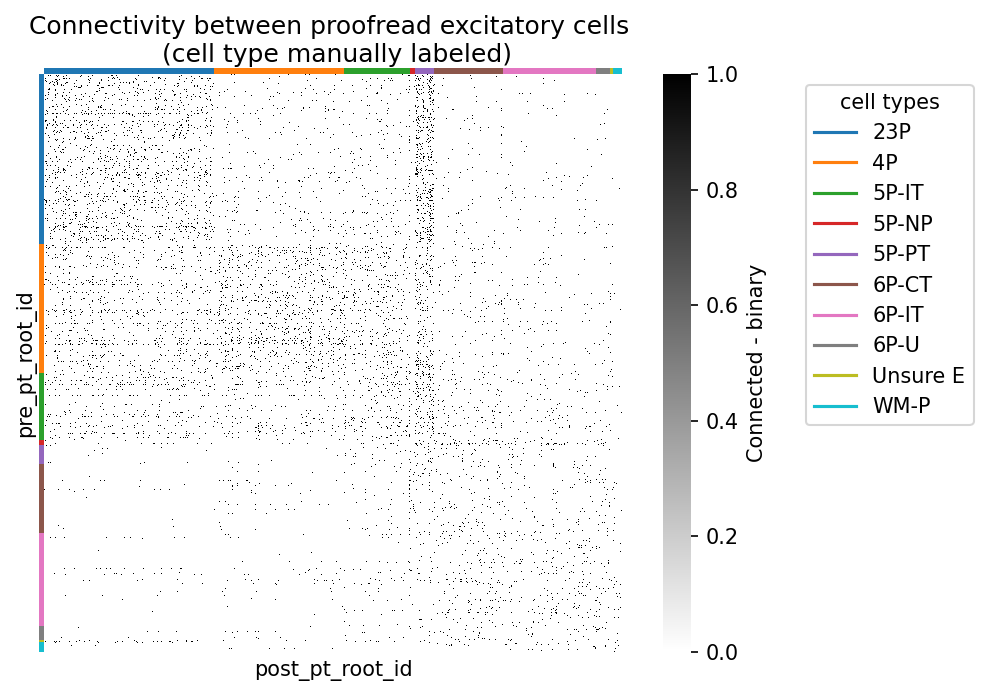

In [24]:
import matplotlib

# add colormap for cell type
cts, ct_idx = np.unique(syn_mat_cell_types, return_inverse=True)
ct_colors = plt.get_cmap("tab10")(ct_idx)

fig, ax = plt.subplots(figsize=(7, 5), dpi=150)
sns.heatmap(syn_mat_ct, cmap="gray_r", xticklabels=[], yticklabels=[], 
            ax=ax, square=True,
            cbar_kws={"label": "Connected - binary"})


# add row and column colors for cell types
for i, color in enumerate(ct_colors):
    ax.add_patch(plt.Rectangle(xy=(-0.01, i), width=0.01, height=1, color=color, lw=0,
                               transform=ax.get_yaxis_transform(), clip_on=False))

for i, color in enumerate(ct_colors):
    ax.add_patch(plt.Rectangle(xy=(i, 1), height=0.01, width=1, color=color, lw=0,
                               transform=ax.get_xaxis_transform(), clip_on=False))

# add a legend for the cell types
legend_elements = [matplotlib.lines.Line2D([0], [0], color=plt.get_cmap("tab10")(i), label=ct) for i, ct in enumerate(cts)]
plt.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1.3, 1), title="cell types")

ax.set_title('Connectivity between proofread excitatory cells \n (cell type manually labeled)')
plt.show()

## Aggregate connectivity across cell types

Sometimes it is more useful to consider connectivity between groups of cells, rather than individual cells--especially as the number of indivudal cells soars into the thousands. In this example we will aggregate synaptic connectivity to broad cell types.

### Merge cell types to synapse table

Here, we can assign a cell type to the pre-synaptic and post-synaptic root id on the connectivity matrix. Given the established `syn_proof_only_df` and the merged cell type table `ct_all_df`, let's consider the connectivity between manually identified cell types:


In [25]:
# Merge the cell types to the presynaptic cell id
syn_proof_ct_df = ( syn_proof_only_df.merge(
    ct_all_df[['pt_root_id','cell_type_manual']], 
    left_on='pre_pt_root_id', 
    right_on='pt_root_id',
    how='left' )
.rename(columns={'cell_type_manual': 'cell_type_pre'})
.drop(columns=['pt_root_id'])
)

# Merge the cell types to the postsynaptic cell id
syn_proof_ct_df = ( syn_proof_ct_df.merge(
    ct_all_df[['pt_root_id','cell_type_manual']], 
    left_on='post_pt_root_id', 
    right_on='pt_root_id',
    how='left' )
.rename(columns={'cell_type_manual': 'cell_type_post'})
.drop(columns=['pt_root_id'])
)

syn_proof_ct_df.head(3)

,id,created,superceded_id,valid,size,pre_pt_supervoxel_id,pre_pt_root_id,post_pt_supervoxel_id,post_pt_root_id,pre_pt_position,post_pt_position,ctr_pt_position,cell_type_pre,cell_type_post
0,174979485,2020-11-04 08:50:39.220791+00:00,NaN,t,4688,90161191099360974,864691135817602127,90161191099310671,864691136674495623,"[184770, 200984, 19986]","[184786, 201052, 19972]","[184816, 200974, 19981]",unknown,5P-IT
1,152094175,2020-11-04 07:20:36.943498+00:00,NaN,t,14020,88401010355440214,864691135778700477,88401010355435596,864691135561699041,"[171952, 194076, 19787]","[171996, 194038, 19786]","[172002, 194074, 19793]",23P,MC
2,161901009,2020-11-04 14:35:02.898645+00:00,NaN,t,668,89030412042836638,864691135817602127,89030480762316394,864691136380816597,"[176280, 165046, 19727]","[176256, 165108, 19730]","[176238, 165052, 19722]",unknown,Unsure E


### Pivot the synapse table to collect cell type connectivity

Using `pandas.pivot()` on the pre- and post-synaptic cell classes, we count the number of connections between:

In [28]:
# Pivot table to get connectivity between cell types
syn_ct_counts = (syn_proof_ct_df.pivot_table(index='cell_type_pre',
                                             columns='cell_type_post',
                                             values='id', aggfunc=lambda x: len(x)).fillna(0)
                 .drop(columns=['Unsure E','Unsure I','Unsure', 'WM-P', 'unknown'], index=['Unsure E','Unsure I','Unsure', 'WM-P', 'unknown'])
                 .astype(int) 
                )

# Sort by names
syn_ct_counts = syn_ct_counts.reindex(sorted(syn_ct_counts.columns), axis=1)
syn_ct_counts = syn_ct_counts.reindex(sorted(syn_ct_counts.index), axis=0)

# consistent axis naming
syn_ct_counts = syn_ct_counts.rename_axis(['presyn cell type'], axis=0)
syn_ct_counts = syn_ct_counts.rename_axis(['postsyn cell type'], axis=1)

### Plot cell connectivity, aggregated by cell type
This now summarizes connectivity between broad cell classes

Text(0.5, 1.0, 'Aggregate Connectivity between proofread cells \n (cell type manually labeled)')

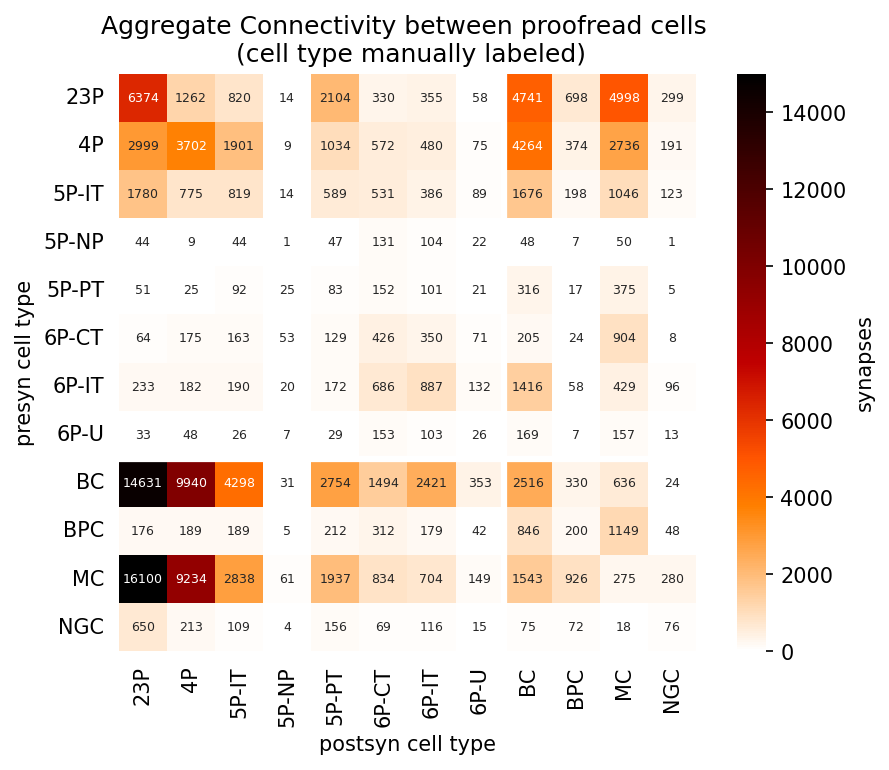

In [29]:
fig, ax = plt.subplots(figsize=(7, 5), dpi=150)

sns.heatmap(syn_ct_counts, cmap="gist_heat_r", annot=True, ax=ax, fmt='d', vmin=0, vmax=15000,
            cbar_kws={'label': 'synapses', 'location': 'right'},
            annot_kws={"fontsize":6},
            square=True)

ax.tick_params(left=False, bottom=False) 
ax.hlines([8], *ax.get_xlim(), color='white',linewidth = 3)
ax.vlines([8], *ax.get_ylim(), color='white',linewidth = 3)

ax.set_title('Aggregate Connectivity between proofread cells \n (cell type manually labeled)')

<h3> Final note </h3>

It is worth keeping in mind that this connectivity matrix is highly dependendant on: 

1. Which set of cell-type labels you include (here: manual labels in the V1 column)
2. Which set of proofread cells you include (here: most strict inclusion for pre- and post-synaptic partners)

The more cells are proofread in the dataset, the more consistency and reproducibility you will get from connecitivty diagrams. See [VORTEX program](/vortex-overview.html) to request specific proofreading.